In [1]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import csv
import time
from os.path import isfile
import pandas as pd
import re
import spacy
import Tools.processing as proc
import matplotlib.pyplot as plt

model = SentenceTransformer('all-mpnet-base-v2')

/home/marcuswrrn/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# Read the CSV file using pandas
df = pd.read_csv('/home/marcuswrrn/Projects/Semantic_Quantification/Semantic_Comparison/archive(2)/sentiment labelled sentences/sentiment labelled sentences/amazon_cells_labelled.txt', sep='\t', header=None, names=['text', 'sentiment'])

df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [4]:
df['embedding'] = df['text'].apply(lambda x: model.encode(x))
df.head()

,text,sentiment,embedding
0,So there is no way for me to plug it in here i...,0,"[-0.008583865, -0.044153374, 0.00012321952, -0..."
1,"Good case, Excellent value.",1,"[0.028298596, 0.0013572105, -0.02037412, 0.072..."
2,Great for the jawbone.,1,"[0.0542514, -0.0025234553, -0.0002885488, -0.0..."
3,Tied to charger for conversations lasting more...,0,"[0.033301294, -7.668971e-05, 0.020432312, -0.0..."
4,The mic is great.,1,"[-0.05145989, -0.022099864, -0.017635694, -0.0..."


In [44]:
anchor_sent = "I wasted my money"
anchor_embed = model.encode(anchor_sent)

df['difference'] = df['embedding'].apply(lambda x: np.abs(anchor_embed - x))
df['similarity'] = df['embedding'].apply(lambda x: float(util.dot_score(anchor_embed, x)[0][0]))
df['denoised'] = df['difference'].apply(lambda x: proc.denoise(x))
df.to_csv("./archive/test.csv")

In [45]:
df_pos = df[df['similarity'] <= 0.3].reset_index(drop=True)
df_neg = df[df['similarity'] >= 0.6].reset_index(drop=True)

similarity_avg_pos = sum(df_pos['similarity'])/len(df_pos)
print(f"Positive similarity: {similarity_avg_pos}")
print(f"Count: {len(df_pos)}")

similarity_avg_neg = sum(df_neg['similarity'])/len(df_neg)
print(f"Negative similarity: {similarity_avg_neg}")
print(f"Count: {len(df_neg)}")

Positive similarity: 0.1387497430692016
Count: 866
Negative similarity: 0.6817724108695984
Count: 6


Anchor sentence: I wasted my money


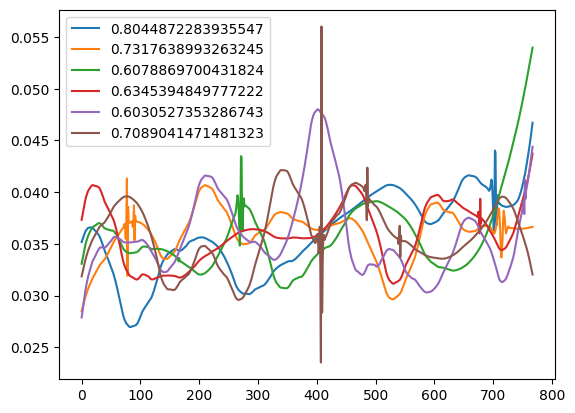

6


In [48]:
# This is unbeleivably stupid
def normalize(vec):
    return vec / np.linalg.norm(vec)

time = np.arange(0, 768)
print(f"Anchor sentence: {anchor_sent}")
for i in range(6):
    plt.plot(time, normalize(df_neg['denoised'][i]), label=f"{df_neg['similarity'][i]}")
    # print(f"Sentence: {df_neg['text'][i]}")
    # print(f"Similarity: {df_neg['similarity'][i]}")
plt.legend()
plt.show()
print(len(df_neg))

Anchor sentence: This is a bad product


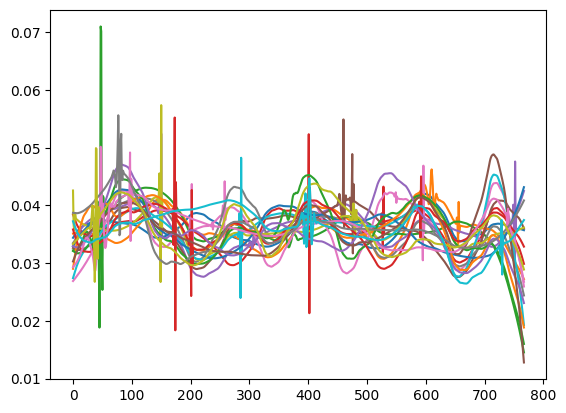

831


In [30]:
time = np.arange(0, 768)
print(f"Anchor sentence: {anchor_sent}")
for i in range(20):
    plt.plot(time, normalize(df_pos['denoised'][i]))
    
    # print(f"Sentence: {df_neg['text'][i]}")
    # print(f"Similarity: {df_neg['similarity'][i]}")
plt.show()
print(len(df_pos))

In [25]:
# GPT trials
sent1 = "As a firefighter, I have the privilege of serving and protecting my community every day."
sent2 = "Being a firefighter can be incredibly dangerous and stressful, and it's not a job for everyone."
sent3 = "I am a firefighter"

enc1 = model.encode(sent1)

enc2 = model.encode(sent2)
enc3 = model.encode(sent3)


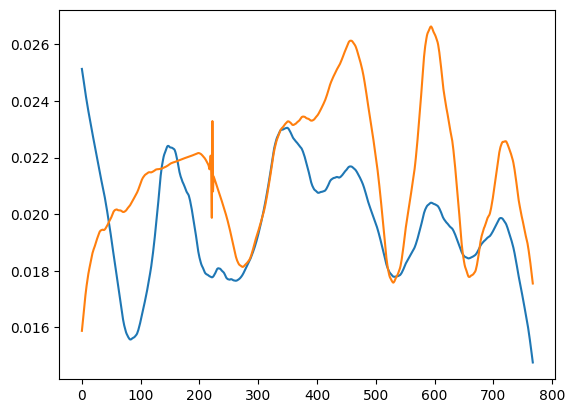

Similarity: tensor([[0.7629]])
Similarity: tensor([[0.7119]])


In [26]:


val1 = proc.denoise(np.abs(enc1 - enc3))
val2 = proc.denoise(np.abs(enc2 - enc3))

time = np.arange(len(val1))

plt.plot(time, val1)
plt.plot(time, val2)
plt.show()
print(f"Similarity: {util.cos_sim(enc3, enc1)}")
print(f"Similarity: {util.cos_sim(enc3, enc2)}")

Using GPT to come up with semantic opposing sentences gives me an idea. What if I train a transformer that is fine tuned to produce sentences of exact opposite meaning